## Colab Setup

In [0]:
# mounting and connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Setup colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import warnings 
warnings.filterwarnings("ignore")

In [0]:
# importing train file from gdrive
link = 'https://drive.google.com/open?id=1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee


In [0]:
# importing labels file from gdrive
link = 'https://drive.google.com/open?id=1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labels.json')

1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr


In [0]:
# importing libraries
import os
import gc
import sys
import math
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from IPython.display import clear_output

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf

In [0]:
# setting up path directory
TRAIN_IMAGE_DIR = Path('/content/drive/My Drive/Projects/iMaterialist/sample/')
ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/My Drive/Projects/iMaterialist/')

## Data Import

In [0]:
# import train file 
import pandas as pd
train = pd.read_csv('train.csv')
train.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [0]:
# extracting image metadata fom json file 
with open(ROOT_DIR/"labels.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [0]:
label_df = pd.DataFrame(label_names).reset_index()
label_df.columns = ['Id','Labels']
label_df.head()

,Id,Labels
0,0,"shirt, blouse"
1,1,"top, t-shirt, sweatshirt"
2,2,sweater
3,3,cardigan
4,4,jacket


In [0]:
segment_df = train
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [0]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


## EDA

<Figure size 1080x504 with 0 Axes>

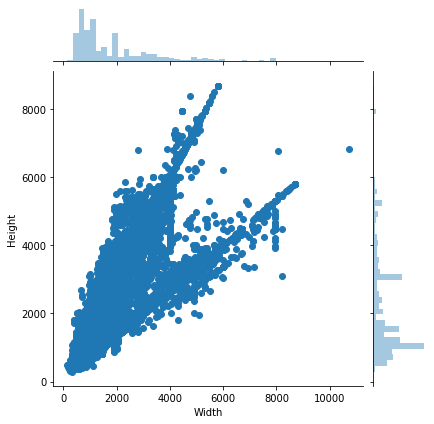

In [0]:
plt.figure(figsize=(15, 7))
sns.jointplot(x=image_df['Width'], y=image_df['Height'])

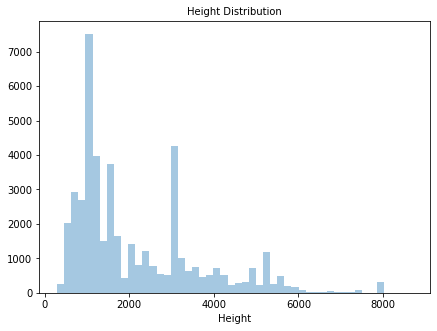

In [0]:
plt.figure(figsize=(7, 5))
sns.distplot(image_df['Height'], kde=False);
plt.title("Height Distribution", fontsize=10)
plt.show()

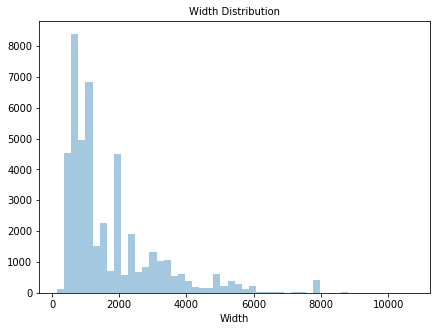

In [0]:
plt.figure(figsize=(7, 5))
sns.distplot(image_df['Width'], kde=False);
plt.title("Width Distribution", fontsize=10)
plt.show()

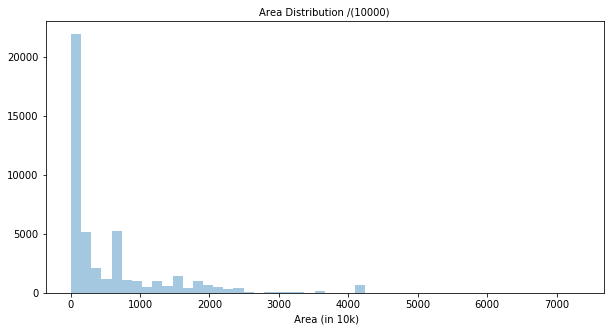

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot((image_df['Height'] * image_df['Width'])/10000, kde=False);
plt.title("Area Distribution /(10000)", fontsize=10)
plt.xlabel(" Area (in 10k)", fontsize=10)
plt.show()

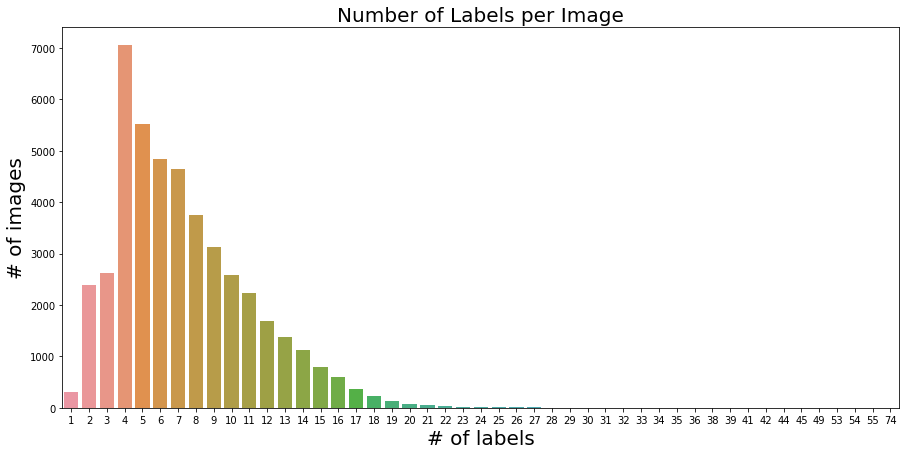

In [0]:
# number of labels per image
labels_per_image = image_df['CategoryId'].map(lambda x:len(x)).value_counts().to_frame().reset_index().sort_values(by = 'index')
labels_per_image.columns = ['#labels','#images']

plt.figure(figsize=(15, 7))
sns.barplot(labels_per_image['#labels'],labels_per_image['#images'])
plt.title("Number of Labels per Image", fontsize=20)
plt.xlabel("# of labels", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

In [0]:
segment_df['CategoryId'] = segment_df['CategoryId'].astype('int64')
labels_per_image2 = segment_df.merge(label_df, how='left', left_on='CategoryId', right_on='Id')
labels_per_image3 = labels_per_image2.groupby('Labels')['ImageId'].nunique().to_frame().reset_index()
labels_per_image3.head()

,Labels,ImageId
0,applique,1687
1,"bag, wallet",6907
2,bead,1755
3,belt,6667
4,bow,391


In [0]:
labels_per_image4 = labels_per_image2.groupby('Labels')['ImageId'].count().to_frame().reset_index()
labels_per_image4.head()

,Labels,ImageId
0,applique,3529
1,"bag, wallet",7217
2,bead,5084
3,belt,6851
4,bow,528


In [0]:
labels_per_image4.to_csv('word_cloud_data.csv')

In [0]:
d = {}
for i in range(len(labels_per_image4)):
    d[labels_per_image4.iloc[i,0]] = labels_per_image4.iloc[i,1]

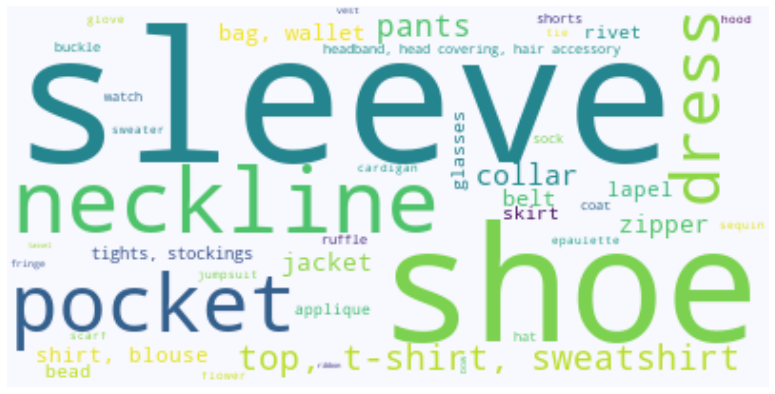

In [0]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='Ghostwhite')
wordcloud.generate_from_frequencies(frequencies=d)

plt.figure(figsize=(25, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

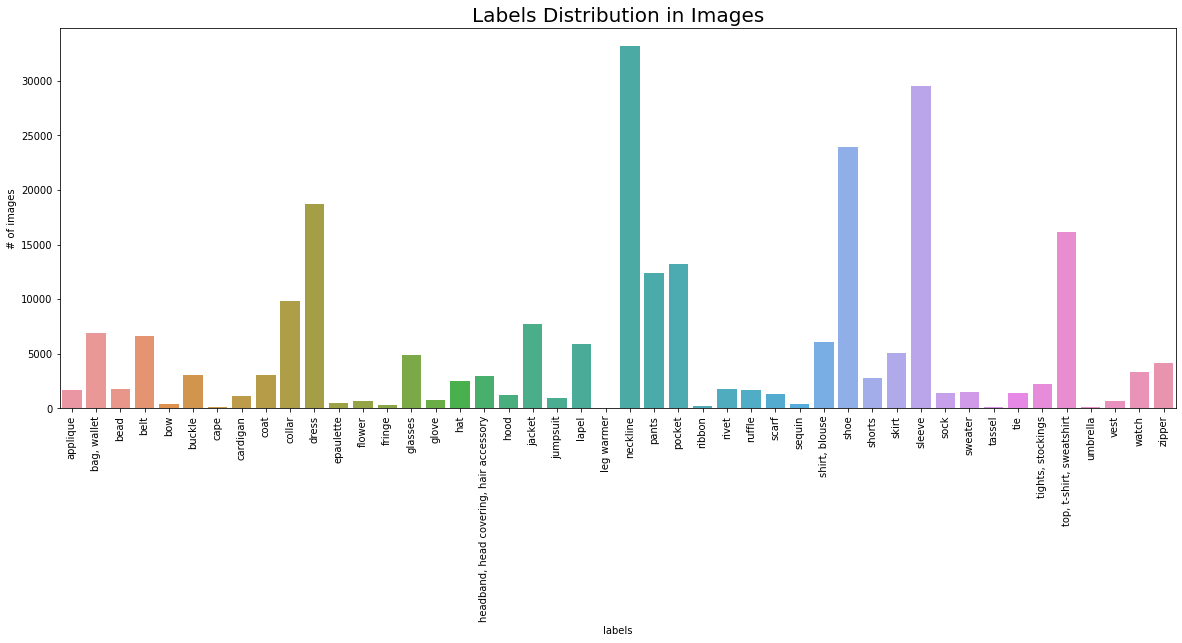

In [0]:
plt.figure(figsize=(20, 7))
sns.barplot(labels_per_image3['Labels'],labels_per_image3['ImageId'])
plt.xticks(rotation=90)
plt.title("Labels Distribution in Images", fontsize=20)
plt.xlabel("labels", fontsize=10)
plt.ylabel("# of images", fontsize=10)
plt.show()

## Data Setup

In [0]:
# Since we are training on ~5k images, we will fetch train data for those 5k images

images = os.listdir(TRAIN_IMAGE_DIR)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
image_df = image_df[image_df.index.isin(uploaded_images['image_name'])]

In [0]:
image_df.shape

(4993, 4)

In [0]:
# Partition data in train and test
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

## Setting up Mask RCNN

In [0]:
# import matterport Mask-RCNN implementation
!git clone https://www.github.com/matterport/Mask_RCNN.git;
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (569/569), done.


Using TensorFlow backend.


In [0]:
# Already have trained weights, we will continue on those weights
pre_trained_weight = '/content/drive/My Drive/Projects/iMaterialist/trained weights/weights_0.08133.h5'

In [0]:
# Set configuration

NUM_CATS = 46  # classification ignoring attributes (only categories)
IMAGE_SIZE = 512 # the image size is set to 512, which is the same as the size of submission masks

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # Batch size - memory error occurs when IMAGES_PER_GPU is too high
    #https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
    
    BACKBONE = 'resnet50' #resnet50 will be lighter than resnet101 for training
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = "none"
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.7

    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 100

    MAX_GT_INSTANCES = 50
    DETECTION_MAX_INSTANCES = 50

    ## balance out losses
    # https://stackoverflow.com/questions/55360262/what-exactly-are-the-losses-in-matterport-mask-r-cnn
    # https://stackoverflow.com/questions/46272841/what-is-the-loss-function-of-the-mask-rcnn
    LOSS_WEIGHTS = {
          "rpn_class_loss": 1.0, # How well the Region Proposal Network separates background with objetcs
          "rpn_bbox_loss": 0.8, # How well the RPN localize objects
          "mrcnn_class_loss": 6.0, # How well the Mask RCNN localize objects
          "mrcnn_bbox_loss": 6.0, # How well the Mask RCNN recognize each class of object
          "mrcnn_mask_loss": 6.0 # How well the Mask RCNN segment objects
    }
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 6.0, 'mrcnn_mask_loss': 6.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

In [0]:
# resizing image to 512X512;
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
#  MaskRCNN Class

class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(TRAIN_IMAGE_DIR/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/content/drive/My Drive/Projects/iMaterialist/sample/1eba2304738d6102cb4e35cc97915103.jpg', ['dress', 'collar', 'sleeve', 'sleeve', 'pocket', 'pocket', 'belt', 'scarf', 'hat', 'glasses'])


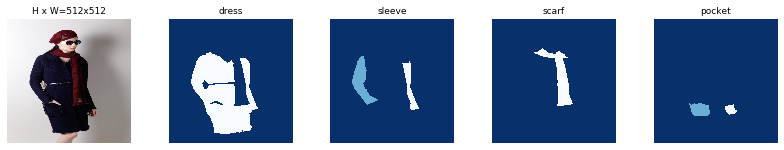

In [0]:
# Visualizing random images
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(1):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [0]:
# Prepare Data
train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

## Training Model

In [0]:
# Image augmentation
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.3)),
        iaa.Sharpen(alpha=(0.0, 0.3)),
    ]),
])

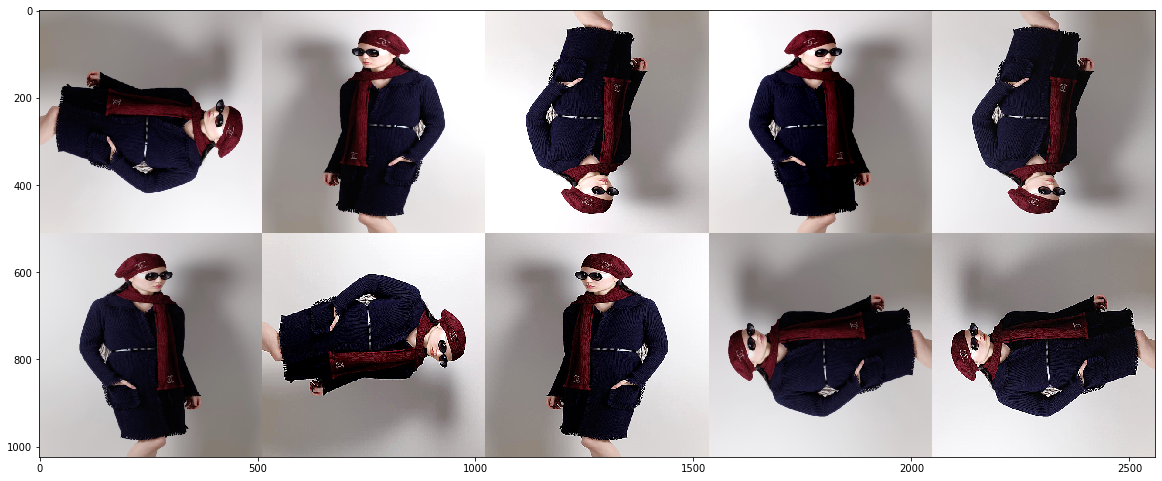

In [0]:
# sample augmentation output
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(20, 10))
_ = plt.imshow(imggrid.astype(int))

In [0]:
# initiating Mask R-CNN training

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR);
model.load_weights(pre_trained_weight, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
# Declaring learning rate
LR = 0.0001

In [0]:
## train head layer alone

# %%time
# model.train(train_dataset, valid_dataset,
#             learning_rate=LR*2,
#             epochs=2, # EPOCHS[0],
#             layers='heads',
#             augmentation=augmentation)
# history = model.keras_model.history.history
# history

In [0]:
# Train all layers
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/4,
            epochs=2,
            layers='all',
            augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]
history = model.keras_model.history.history


Starting at epoch 0. LR=2.5e-05

Checkpoint Path: /content/fashion20191211T1601/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

In [0]:
#reducing learning rate and training again

%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/8,
            epochs=5,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=1.25e-05

Checkpoint Path: /content/fashion20191211T1601/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

In [0]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,6.307518,0.045938,0.740632,1.857804,1.878627,1.784510,6.603268,0.046959,0.771817,2.009002,1.922910,1.852573
2,6.460531,0.055555,0.842531,1.879245,1.901543,1.781651,6.656547,0.053115,0.854365,1.997372,1.906473,1.845215
3,6.349557,0.053273,0.905184,1.770557,1.848883,1.771653,6.510195,0.053940,0.916967,1.863990,1.859340,1.815950
4,6.437570,0.059940,0.928501,1.816903,1.864169,1.768050,6.576983,0.057435,0.941307,1.910651,1.844846,1.822738
5,6.350489,0.089672,1.176897,1.658743,1.696868,1.728303,6.581058,0.058953,0.993048,1.869035,1.848320,1.811695


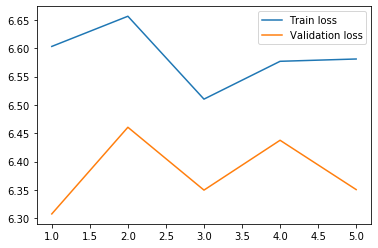

In [0]:
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.legend()

In [0]:
# find best epoch
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  1
Valid loss:  6.307517833709717


In [0]:
# Picking the location of our best model weights
glob_list = glob.glob(f'/content/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [0]:
# model_path = '/content/fashion20191109T2055/mask_rcnn_fashion_0007.h5'

## Prediction

In [0]:
# Prediction, this cell defines InferenceConfig and loads the best trained model.

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 1


In [0]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

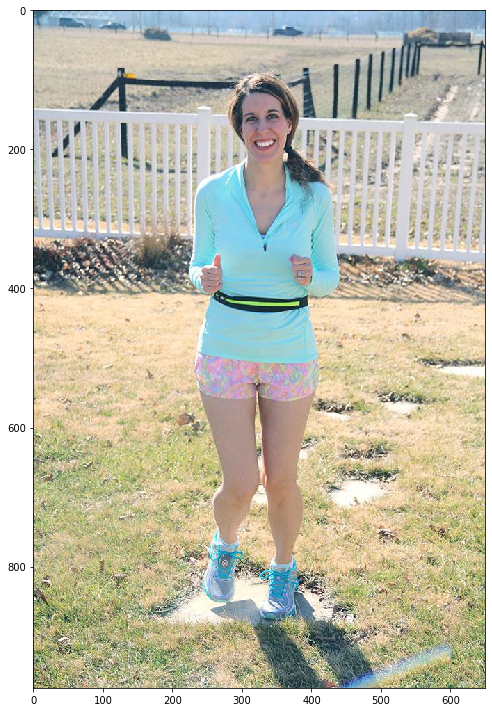

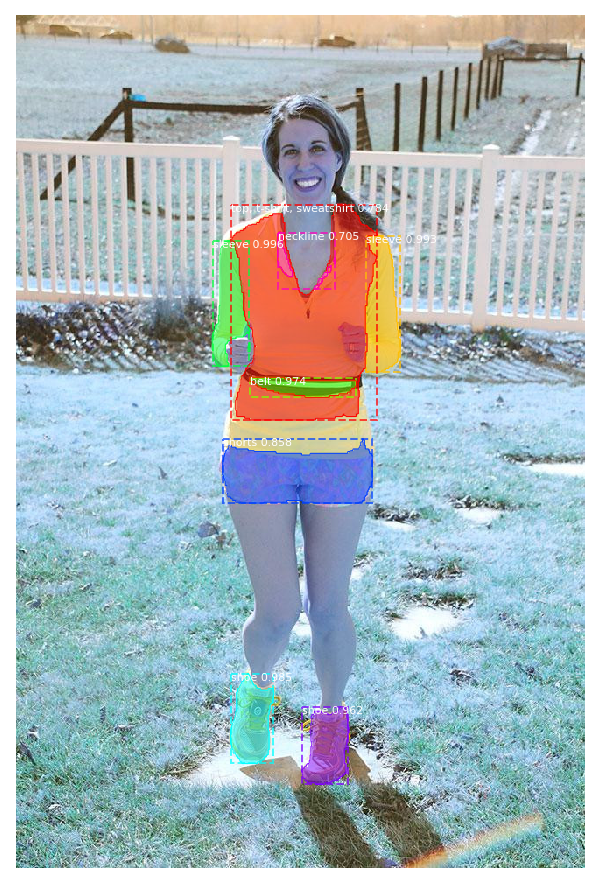

In [0]:
# Let’s load an image and try to see how the model performs. You can use any of your images to test the model.

# Load a random image from the images folder
import skimage.io
image_path = str(ROOT_DIR/'test_image.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(skimage.io.imread(image_path))

img = skimage.io.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(image_path)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'])

In [0]:
submission_file = pd.read_csv("/content/drive/My Drive/Projects/iMaterialist/sample_submission.csv")
submission_file.head()

,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,1 1,23
1,0046f98599f05fd7233973e430d6d04d.jpg,1 1,23
2,004e9e21cd1aca568a8ffc77a54638ce.jpg,1 1,23
3,005b37fce3c0f641d327d95dd832f51b.jpg,1 1,23
4,0094940c58c343b742f48ae26eb5e9fa.jpg,1 1,23


In [0]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [0]:
# Run prediction on test
%%time
test_path = Path('/content/drive/My Drive/Projects/iMaterialist/test')
sub_list = []
missing_count = 0
for i, row in tqdm(submission_file.iterrows(), total=len(submission_file)):
    image = resize_image(str(test_path/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

100%|██████████| 3200/3200 [1:16:47<00:00,  1.40s/it]

CPU times: user 26min 5s, sys: 7min 11s, total: 33min 17s
Wall time: 1h 16min 47s


In [0]:
# save predicted data in submission file to upload in Kaggle
submission_df = pd.DataFrame(sub_list, columns=submission_file.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)

submission_df.to_csv(ROOT_DIR/"submission.csv", index=False)

submission_df.head()

Total image results:  3200
Missing Images:  6


,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,73080 3 73579 19 74086 23 74549 72 75054 78 75...,31
1,003d41dd20f271d27219fe7ee6de727d.jpg,169653 30 170156 80 170668 84 171179 88 171691...,31
2,003d41dd20f271d27219fe7ee6de727d.jpg,107684 8 108196 8 108707 10 109219 11 109731 1...,33
3,003d41dd20f271d27219fe7ee6de727d.jpg,112845 8 113355 10 113866 12 114376 15 114871 ...,1
4,003d41dd20f271d27219fe7ee6de727d.jpg,88467 39 88962 72 89468 83 89976 90 90485 95 9...,8


In [0]:
import time
time.sleep(5)

from google.colab import files
files.download('/content/submission.csv') 

## Live Implementation

In [0]:
import os
os.chdir('/content/')

In [0]:
# function to capture video through api call
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
# # Test if above function is working
# from IPython.display import Image
# while True:
#   try:
#     filename = take_photo()
    
#     # Show the image which was just taken.
#     display(Image(filename))
#   except Exception as err:
#     # Errors will be thrown if the user does not have a webcam or if they do not
#     # grant the page permission to access it.
#     print(str(err))

In [0]:
# Mask RCNN for live video segmentation

def random_colors(N):
    np.random.seed(1) # to make sure colors are consistent everytime
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image

# this will run if we want to test this directly
if __name__ == '__main__':
    """
        test everything
    """
    class InferenceConfig(FashionConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    config = InferenceConfig()

    model = modellib.MaskRCNN( mode="inference", model_dir=ROOT_DIR, config=config)
    model.load_weights(pre_trained_weight, by_name=True)

    # while True:
    for i in range(5):
        take_photo()
        image_path = str(ROOT_DIR/'photo.jpg')
        img = skimage.io.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            
            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            
            masks, rois = refine_masks(masks, rois)
        else:
            masks, rois = r['masks'], r['rois']
        
        frame = display_instances(img, rois, masks, r['class_ids'], ['bg']+label_names, r['scores'])
        clear_output()
        plt.figure(figsize=(20,10))
        plt.imshow(frame)
        plt.show()

## Video Input

In [0]:
def resize_image2(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    
    # We use a K80 GPU with 12GB memory which can fit just 1 image - more than that we are getting memory error
    batch_size = 1
    VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, "save")

    class InferenceConfig(FashionConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    config = InferenceConfig()

    model = modellib.MaskRCNN( mode="inference", model_dir=ROOT_DIR, config=config)
    model.load_weights(pre_trained_weight, by_name=True)

    capture = cv2.VideoCapture(str(ROOT_DIR/'samp_vid.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    # capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    # capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame = resize_image2(frame)
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], ['bg']+label_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()

In [0]:
video = cv2.VideoCapture(str(ROOT_DIR/'samp_vid.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0


In [0]:
def make_video(outvid, images=None, fps=30, size=None,is_color=True, format="FMP4"):
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(ROOT_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7fbdd6dbcf90>

In [0]:
from google.colab import files
files.download('/content/out.mp4')